# DSCI 572 Lecture 3

floating point numbers

In [45]:
# motivating example
0.3 - 0.2 - 0.1 

-2.7755575615628914e-17

(demonstrate this in other languages)

Funny story: during my undergrad I send a bug report to MathWorks because I observed this behaviour in MATLAB. I got a very polite and patient response... 

#### Review from DSCI 521 of binary numbers and representations of integers (5-10 min)

In [47]:
"{0:b}".format(11)

'1011'

Read this as $$1\times 2^3 + 0\times 2^2 + 1\times 2^1 + 1\times 2^0 = 8+2+1 = 11$$

- In practice there's one bit used as the "sign bit"
- Since we don't need both positive 0 and negative 0, we keep one extra number on the negative side
- So a 64-bit integer ranges from $-2^{63}$ to $2^{63}-1$, inclusive.
- Python is special because it takes care of this for you behind the scenes. 

In [34]:
type(2**100) # Python is special

int

In [35]:
%load_ext rpy2.ipython

In [36]:
%%R 
x = 1L
for (i in 1:30) { # try 30 and 31
  x = x * 2L
}
print(x)

[1] 1073741824


We conclude that R is using 32-bit integers. 

#### Review scientific notation (0 min)

In [37]:
23423423974482344.0

2.3423423974482344e+16

#### decimal numbers in binary (5 min)

Consider the number $101.11$.

Interpretation:

$$1\times 2^2 + 0\times 2^1 + 1\times 2^0 + 1\times 2^{-1} + 1\times 2^{-2} = 4+1+0.5+0.25 = 5.75$$

Exercise: convert $1.10101$ to base 10.



#### Explain floating point system (20 min)

Everything is represented in "scientific notation". In other words, $A \times 10^B$. Except in this case it's more like $1.M \times 2^E$, where $M$ is called the mantissa and $E$ is called the exponent.

Examples:

| number in base 10 | scientific notation | M (binary) | E (binary) | 
|--------------------|---------------------|-------------|--------|
|  2                  |  $1\times 2^1$    |  0           | 1      | 
| 0.375               |  $1.5\times 2^{-2} $ |  1      |  -10  |
| 0.1                 |  $1.?? \times 2^{-4}$ | ?? | -100  |

**IEEE floating point standard**: https://en.wikipedia.org/wiki/IEEE_floating_point

Key info: in IEEE double precision, we use 53 bits for the mantissa and 11 bits for the exponent (total = 64 bits).

**Exercise** (5-10 min): calculate the smallest and largest possible floating point numbers.

Then empirically check this. The largest one is about right. The smallest one is not right. This is because of sub-normal numbers (out of scope of lecture).

NOTE: Python has a special behaviour that we need to watch out for. If you do something like `10**1000` you will get a giant integer. That's because Python has a dynamically expanding integer type. This has nothing to do with floating point representations, which are the thing we really care about for scientific computation (not to mention that most other languages, including R, do not do this). So, when playing around, make sure you write `10**1000.0` to ensure it's a floating point. Or `1e1000` but that doesn't work for other bases. 

(Also, and this is _REALLY_ out of scope but just FYI if anyone cares, in some languages `1eX` and `10^X` will return slightly different answers, if the language uses a special routine for `1eX` that is more optimized than the generral power function. I cannot imagine this ever mattering to any of us.)



In [55]:
2**1024.0

OverflowError: (34, 'Result too large')

In [56]:
2**1023.0

8.98846567431158e+307

Below are two pieces of code that more-or-less do the same thing, namely convert a float to its binary representation.

In [1]:
# from http://stackoverflow.com/questions/16444726/binary-representation-of-float-in-python-bits-not-hex

import struct
def binary(num):
    # Struct can provide us with the float packed into bytes. The '!' ensures that
    # it's in network byte order (big-endian) and the 'f' says that it should be
    # packed as a float. Alternatively, for double-precision, you could use 'd'.
    packed = struct.pack('!d', num)
#     print('Packed: %s' % repr(packed))

    # For each character in the returned string, we'll turn it into its corresponding
    # integer code point
    # 
    # [62, 163, 215, 10] = [ord(c) for c in '>\xa3\xd7\n']
#     integers = [ord(c) for c in packed]
    integers = [c for c in packed]
#     print('Integers: %s' % integers)

    # For each integer, we'll convert it to its binary representation.
    binaries = [bin(i) for i in integers]
#     print('Binaries: %s' % binaries)

    # Now strip off the '0b' from each of these
    stripped_binaries = [s.replace('0b', '') for s in binaries]
#     print('Stripped: %s' % stripped_binaries)

    # Pad each byte's binary representation's with 0's to make sure it has all 8 bits:
    #
    # ['00111110', '10100011', '11010111', '00001010']
    padded = [s.rjust(8, '0') for s in stripped_binaries]
#     print('Padded: %s' % padded)

    # At this point, we have each of the bytes for the network byte ordered float
    # in an array as binary strings. Now we just concatenate them to get the total
    # representation of the float:
    final = ''.join(padded)
    
    print('Sign: %s' % final[0])
    print('Exponent: %s' % final[1:12])
    e1023 = "{:011b}".format(int(final[1:12],2)-1023)
    print('Exponent - 1023: %s' % e1023)
    print('Mantissa: %s' % final[12:])
    
    return final

In [7]:
def float_to_bin(x): # does the same as the above, basically.
    x = float(x)
    if x == 0:
        return "0" * 64
    w, sign = (float.hex(x), 0) if x > 0 else (float.hex(x)[1:], 1)
    mantissa, exp = int(w[4:17], 16), int(w[18:])
    return "{}{:011b}{:052b}".format(sign, exp + 1023, mantissa)
#     print('Sign: %s' % sign)
#     print("Exponent: %s" % exp)
#     print("Mantissa: %s" % mantissa)

float_to_bin(8) 

'0100000000100000000000000000000000000000000000000000000000000000'

In [57]:
b = binary(0.1)

Sign: 0
Exponent: 01111111011
Exponent - 1023: -0000000100
Mantissa: 1001100110011001100110011001100110011001100110011010


#### some take home messages (!!)

- numbers are not represented exactly
- most calculations are "wrong"
- when these errors are introduced, **you might not get an error message or warning**
- most numbers cannot be represented
- even most _integers_ cannot be represented as floating point numbers
- there is a biggest number
- there is a smallest number
- most environments you'll encounter will use IEEE double precision... but others do exist (especially single precision)

#### spacing between numbers

Imagine you were in the decimal system (not binary), and were using scientific notation but you were only allowed 3 digits after the decimal point. In-class exercise: how large is the _spacing_ between the given number and the _next largest number that we can represent_?

1. $1.259$
2. $8.982$
3. $3.432\times 10^2$
4. $0.001\times 10^1$

Conclusion: we only need to look at the exponent. 

The same goes for binary. The steps happen at every power of 2 instead of 10, and we have way more digits after the decimal (52 instead of 10), but everything else is pretty much the same.

So the spacing size, as a function of the number itself, is a staircase function. 


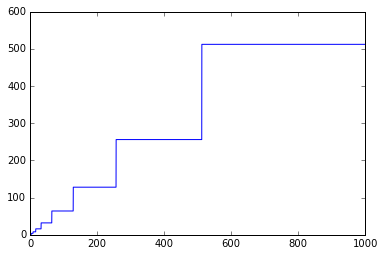

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(1,1000,1e5)
spacing = 2**np.floor(np.log2(x))
plt.plot(x, spacing)

In [65]:
2**-52

2.220446049250313e-16

The steps get bigger, but the trend is a straight line. In other words, if we zoom out we see that the spacing size is _proportional to the number itself_. 

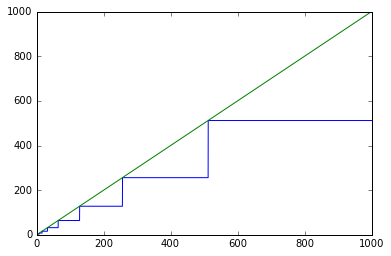

In [21]:
plt.plot(x, spacing)
plt.plot(x,x)

We can also look on a log-log scale

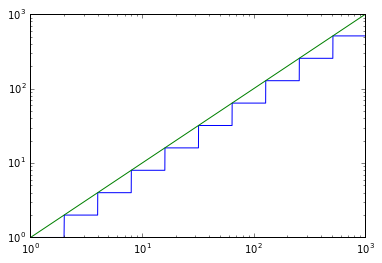

In [23]:
plt.loglog(x,spacing)
plt.loglog(x,x)

#### order of operations

Consider the following:

In [61]:
1e16 + 1 + 1 == 1e16

True

In [59]:
1e16 + 2 == 1e16

False

In [62]:
1e40 + 10000000 == 1e40

True

In [63]:
1+1e-20 == 1

True

We now understand the above, given our new knowledge. The spacing between $10^{16}$ and the next largest number must be more than 2, so when 1 is added to $10^{16}$ we round back down to $10^{16}$. But consider the below...

In [2]:
1 + 1 + 1e16 == 1e16

False

What?? But we just said...  but ...

This is surprising because we changed the order and got different results. To put it more clearly,

In [3]:
1e16+1+1 == 1+1+1e16

False

What's happening here is that we do operations from left to right. So when we first do 1+1 we get 2. And I picked $10^{16}$ on purpose so that the spacing is more than 2 but less than 4. So when we add 2 to $10^{16}$ we do get far enough to round _up_ to the next number. In other words, the order of operations doesn't matter on paper, but it can matter in code due to floating point issues. 


(begin bonus) By the way, what _is_ the spacing at $10^{16}$? We need to find the larest power of 2 that is less than $10^{16}$, which happens to be

In [13]:
2.0**53 

9007199254740992.0

In [14]:
# make it easier to read
'%g' % 2.0**53

'9.0072e+15'

Ok this looks good. So now we just need to do $2^{53}\times 2^{-52}=2$. So the spacing is exactly 2. I guess we round up! (end bonus)

#### log-sum-exp

In the lab you are asked to implement logistic regression. Here we'll consider the binary classification case. To make things cleaner let's also assume $d=1$. 

The loss function is 

In [68]:
import numpy as np

def loss_lr_1D(w, x, y):
    return np.sum(np.log(1 + np.exp(-y*w*x)))


N = 100
x = np.random.randn(N)
x[1:10] *= 1e5
w = np.random.randn()
y = np.random.choice([-1,+1], size=N)

loss_lr_1D(w,x,y)

//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: overflow encountered in exp


inf

What we are doing here?

$$\mathcal{L}(w) =  \sum_{n=1}^N \log \left( 1+ \exp(-y_nwx_n) \right) $$

The key is that we're computing $\log(1+\exp(z))$ and getting an overflow when $z\gg 1$. 

(Note: when doing the optimization, we only really need the gradient of the loss, so this isn't a completely realistic concern. But it happens for real for multi-class.)

But when $z\gg1$ we can say $1+\exp(z)\approx \exp(z)$ and in that case  

$$\log(1+\exp(z))\approx \log(\exp(z)) = z$$

We can try it...

In [69]:
def log_1_plus_exp(z):
    return np.log(1+np.exp(z))

def log_1_plus_exp_safe(z):
    if z > 100:
        return z
    else:
        return np.log(1+np.exp(z))


print(log_1_plus_exp(0))
print(log_1_plus_exp_safe(0))

print(log_1_plus_exp(110))
print(log_1_plus_exp_safe(110))

print(log_1_plus_exp(1000))
print(log_1_plus_exp_safe(1000))


0.69314718056
0.69314718056
110.0
110
inf
1000


//anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


(optional) What about underflow?

In [31]:
print(log_1_plus_exp(-100))

0.0


Why? Because

In [35]:
np.exp(-100)

3.7200759760208361e-44

The above is not zero. Hmm. But...

In [36]:
1+np.exp(-100)

1.0

In [37]:
1+np.exp(-100)==1

True

Aha! The above equals 1. So that's the problem.

Well, when $z\ll -1$ then $\exp(z)$ is very small. Let's call it $\epsilon$. So we have 

$$\log(1+\epsilon)\approx \epsilon$$ for $\epsilon$ very small (this comes from the Taylor expansion). 

So now we can say

$$\log(1+\exp(z))\approx\exp(z)$$ when $$z\ll -1$$. 

In [38]:
def log_1_plus_exp_safer(z):
    if z > 100:
        return z
    elif z < -100:
        return np.exp(z)
    else:
        return np.log(1+np.exp(z))

0.69314718056
0.69314718056
110.0
110
inf
1000
4.53988992169e-05
4.53988992169e-05
0.0
1.68891188022e-48
0.0
0.0


/Users/mgelbart/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [39]:
# both ok
print(log_1_plus_exp(0))
print(log_1_plus_exp_safer(0))

0.69314718056
0.69314718056


In [40]:
# both OK (but approximation is invoked)
print(log_1_plus_exp(110))
print(log_1_plus_exp_safer(110))

110.0
110


In [41]:
# only safer version works
print(log_1_plus_exp(1000))
print(log_1_plus_exp_safer(1000))

inf
1000


/Users/mgelbart/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


In [42]:
# both OK
print(log_1_plus_exp(-10))
print(log_1_plus_exp_safer(-10))


4.53988992169e-05
4.53988992169e-05


In [43]:
# only safer version works
print(log_1_plus_exp(-110))
print(log_1_plus_exp_safer(-110))


0.0
1.68891188022e-48


In [44]:
# both fail
print(log_1_plus_exp(-1000))
print(log_1_plus_exp_safer(-1000))

0.0
0.0


#### more take-home messages

- by combining an understanding of floating point errors and math, we can write better code
- this is one (of many) reasons why we use libraries like sklearn rather than implementing things ourself. other reasons: speed, edge cases, updates over time, less likely to contain a bug.


Using a careful analysis of floating point numbers you can also reason about what the conditions should be. I just picked -100 and 100 arbitrarily. It turns out my choice was imperfect

In [45]:
print(log_1_plus_exp_safer(-99))

0.0


It turns out +100 and -30 are a pretty good choices. These require careful reasoning (beyond the scope here, ask if you're interested).

#### moving to $d>1$ and multi-class

When $d>1$ not much changes, except that your $z$ above is actually a dot product of a $w$-vector and an $x$-vector, so getting big numbers in there starts to be a much bigger problem. The above is then even more important. 

Imagine $d=1000000$. Even if these numbers look like random noise (both positive and negative, cancelling each other out) by the central limit theorem their sum will grow like $\sqrt{N}$ and eventually overflow will be a problem. You only need to get to $z=1000$ before problems hit.

When the number of classes change then things change more substantially. In particular with $K$ classes the $\log(1+\exp(z))$ flavour changes to

$$\log\left(\sum_{k=1}^K \exp(z_k)\right)$$

In that case we play a different trick which is to pull out the max $z_k$. More info [here](https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/) and an optional question in lab.

### inverting matrices

Sometime we take the inverse of a matrix. For example:

- [DSCI 561 lecture 7](https://github.ubc.ca/ubc-mds-2016/DSCI_561_regr-1_students/blob/master/lectures/lect07_diagnostics.pdf), slide 6
- [DSCI 553 lecture 6](https://github.ubc.ca/ubc-mds-2016/DSCI_553_stat-inf-2_students/blob/master/Lecture6scrb.pdf),  slide 5

Key point: _this is almost always a bad idea!_

- If you actually need the inverse, then you must compute it
- But in real situations you almost always need to solve $Ax=b$ given some $b$
- In this case, use a solve function to compute this directly, rather than going to $x=A^{-1}b$.

In [70]:
import numpy as np
import numpy.linalg as npla

A = np.random.rand(3,3) # random 3x3 matrix
b = np.random.rand(3)

x1 = npla.inv(A) @ b

In [71]:
x2 = npla.solve(A, b)

In [72]:
np.allclose(x1,x2) # looks good

True

In [76]:
n = 250
A = np.vander(np.random.rand(n))
b = np.random.rand(n)

y1 = npla.inv(A) @ b

In [77]:
y2 = npla.solve(A,b)

In [78]:
np.allclose(y1,y2)

False

In [79]:
np.max(y1-y2)

5.6760089777294697e+96

What happened??

Well, we're not really going to go into this. There are courses on this like CPSC 302 and 402. But, basically, just don't compute the inverse if you don't have to...